In [3]:
#Import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabAPI/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d amanalisiddiqui/fraud-detection-dataset -p /content/drive/MyDrive/Datasets/

Dataset URL: https://www.kaggle.com/datasets/amanalisiddiqui/fraud-detection-dataset
License(s): MIT
 93% 165M/178M [00:01<00:00, 103MB/s]
100% 178M/178M [00:01<00:00, 155MB/s]


In [ ]:
!unzip /content/drive/MyDrive/Datasets/fraud-detection-dataset.zip -d /content/drive/MyDrive/Datasets/fraud-detection


Archive:  /content/drive/MyDrive/Datasets/fraud-detection-dataset.zip
  inflating: /content/drive/MyDrive/Datasets/fraud-detection/AIML Dataset.csv  


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##Lecture et prise en main de la data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/fraud-detection/AIML Dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.shape

(6362620, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.isnull().any().sum()

np.int64(0)

Pas de valeurs manquantes dans la data

In [9]:
df.duplicated().any()

np.False_

Pas de doublons non plus

In [10]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [11]:
df.isFraud.unique()

array([0, 1])

In [12]:
df.isFraud.value_counts()

,count
isFraud,
0,6354407
1,8213


On peut remarquer que la data est tès déséquilibré, faudra donc en tenir compte dans le split en train et test

In [13]:
df.isFraud.value_counts()/len(df)*100

,count
isFraud,
0,99.870918
1,0.129082


Seulement **0,12%** des transactions sont frauduleuses

In [14]:
firstletter = df.nameDest.apply(lambda x : x[0])
firstletter.value_counts()

,count
nameDest,
C,4211125
M,2151495


On a que deux types de destinataires, des clients (personne normal) pour **C** et des marchands pour **M**

In [15]:
df[['type','isFraud']].value_counts()

,,count
type,isFraud,
CASH_OUT,0,2233384
PAYMENT,0,2151495
CASH_IN,0,1399284
TRANSFER,0,528812
DEBIT,0,41432
CASH_OUT,1,4116
TRANSFER,1,4097


On remarque qu'il y'a que des transactions de type CASH_OUT et TRANSFER qui ont été jugée frauduleuses, donc on peut reduire notre dataset à ces deux types de transactions

##Data Cleaning

In [16]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [17]:
#On commmence par supprimer les colonnes qui ne nous intéressent pas
colsup = ['step', 'nameOrig', 'isFlaggedFraud']
df.drop(colsup, axis=1, inplace=True)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,M1979787155,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,M2044282225,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,C553264065,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,C38997010,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,M1230701703,0.0,0.0,0


In [18]:
#On conserve que les transactions de type cash_out et transfer
df = df[df.type.isin(['CASH_OUT', 'TRANSFER'])]
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.0,0.0,C553264065,0.0,0.00,1
3,CASH_OUT,181.00,181.0,0.0,C38997010,21182.0,0.00,1
15,CASH_OUT,229133.94,15325.0,0.0,C476402209,5083.0,51513.44,0
19,TRANSFER,215310.30,705.0,0.0,C1100439041,22425.0,0.00,0
24,TRANSFER,311685.89,10835.0,0.0,C932583850,6267.0,2719172.89,0


On normalise la numérotation des index !

In [19]:
df.reset_index(drop=True, inplace=True)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,181.00,181.0,0.0,C553264065,0.0,0.00,1
1,CASH_OUT,181.00,181.0,0.0,C38997010,21182.0,0.00,1
2,CASH_OUT,229133.94,15325.0,0.0,C476402209,5083.0,51513.44,0
3,TRANSFER,215310.30,705.0,0.0,C1100439041,22425.0,0.00,0
4,TRANSFER,311685.89,10835.0,0.0,C932583850,6267.0,2719172.89,0


In [20]:
df.shape

(2770409, 8)

On passe de 6 à 2 millions de lignes

In [21]:
df.isFraud.value_counts()/len(df)*100

,count
isFraud,
0,99.703546
1,0.296454


In [22]:
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06,2.770409e+06
mean,3.175361e+05,4.764308e+04,1.609190e+04,1.703551e+06,2.049734e+06,2.964544e-03
std,8.877897e+05,2.513251e+05,1.512558e+05,4.225550e+06,4.676990e+06,5.436687e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.297354e+04,0.000000e+00,0.000000e+00,1.280734e+05,3.272891e+05,0.000000e+00
50%,1.712609e+05,3.039600e+02,0.000000e+00,5.557100e+05,8.280539e+05,0.000000e+00
75%,3.067912e+05,3.099700e+04,0.000000e+00,1.735900e+06,2.122198e+06,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


* On observe des valeurs nulles pour amount, oldbalanceorg ect.
* Techniquement c'est impossible d'envoyer de l'argent alors que le compte d'origine est vide !

In [23]:
# Verifions que amount = oldbalanceorg - newbalanceorg
(df.amount == df.oldbalanceOrg - df.newbalanceOrig).value_counts()

,count
False,2616656
True,153753


**2 616 656** transactions ne respectent pas cette règle. On a potentiellement des erreurs ou des valeurs supposées incomplètes !

In [24]:
# De meme amount doit etre egal à newbalancedest - oldbalancedest
(df.amount == df.newbalanceDest - df.oldbalanceDest).value_counts()

,count
False,2011705
True,758704


Pareil, on est censé avoir que des True normalement

In [25]:
df.drop('nameDest', axis=1 ,inplace=True)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [26]:
# on map tranfer par 1 et cash_out par 0
df.type = df.type.map({'TRANSFER':1, 'CASH_OUT':0})
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,181.00,181.0,0.0,0.0,0.00,1
1,0,181.00,181.0,0.0,21182.0,0.00,1
2,0,229133.94,15325.0,0.0,5083.0,51513.44,0
3,1,215310.30,705.0,0.0,22425.0,0.00,0
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [27]:
df.dtypes

,0
type,int64
amount,float64
oldbalanceOrg,float64
newbalanceOrig,float64
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


## EDA : Analyse exploratoire

In [28]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,181.00,181.0,0.0,0.0,0.00,1
1,0,181.00,181.0,0.0,21182.0,0.00,1
2,0,229133.94,15325.0,0.0,5083.0,51513.44,0
3,1,215310.30,705.0,0.0,22425.0,0.00,0
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0


<Axes: xlabel='isFraud', ylabel='count'>

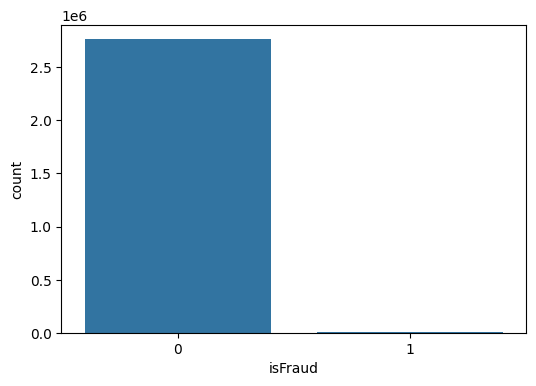

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)

La proportion des fraudes est tellemeent faible qu'on voit à peine la barre

<Axes: >

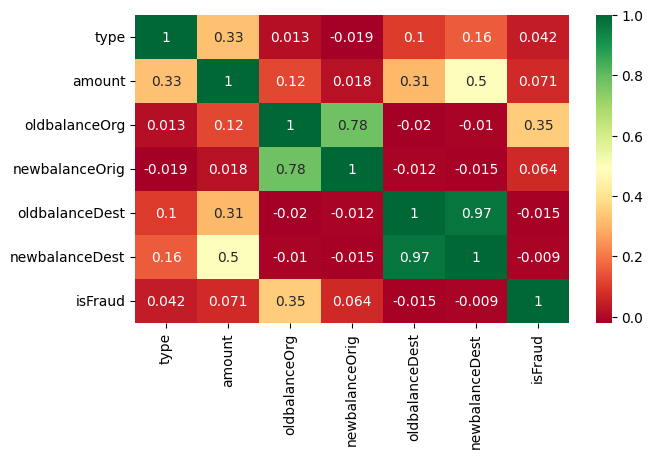

In [30]:
plt.figure(figsize=(7,4))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

<Axes: >

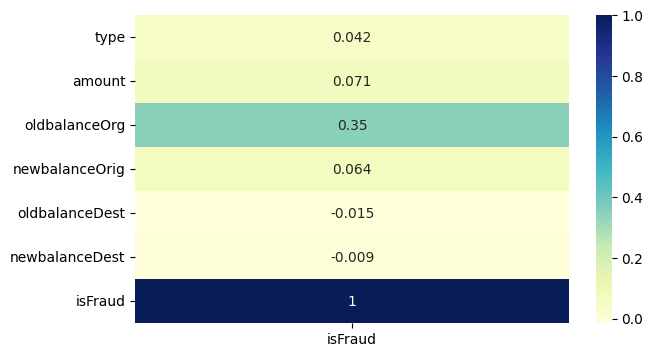

In [31]:
plt.figure(figsize=(7,4))
sns.heatmap(df.corr()[['isFraud']], annot=True, cmap='YlGnBu')

* isFraud n'a pas vraiment de corrélation elevée avec les autres variables excepté le **oldbalanceOrg**
* En situation réelle l'on doit chercher à ajouter ou trouver de nouvelles variables qui ont une réelle infulence sur la fraud afin d'avoir des prédictions qui se rapprochent le plus de la réalité

(0.0, 3000000.0)

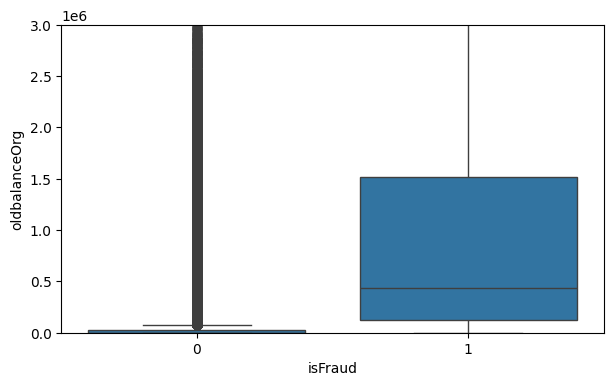

In [32]:
plt.figure(figsize=(7,4))
sns.boxplot(y='oldbalanceOrg', x='isFraud', data=df)
plt.ylim(0, 3000000)

In [33]:
df.oldbalanceOrg.describe()

,oldbalanceOrg
count,2.770409e+06
mean,4.764308e+04
std,2.513251e+05
min,0.000000e+00
25%,0.000000e+00
50%,3.039600e+02
75%,3.099700e+04
max,5.958504e+07


# Modélisation
Comme je l'ai mentinonné précédemment, le dataset n'a pas assez de variables qui influent réellement sur la fraude
* pour la modelisation je retiendrai que les variables avec une corrélation au moins postives
* Soit type, amount, oldbalanceOrg



In [34]:
X = df[['type','amount','oldbalanceOrg']]
X.head()


,type,amount,oldbalanceOrg
0,1,181.00,181.0
1,0,181.00,181.0
2,0,229133.94,15325.0
3,1,215310.30,705.0
4,1,311685.89,10835.0


In [35]:
y = df['isFraud']
y.head()

,isFraud
0,1
1,1
2,0
3,0
4,0


In [36]:
#découpage entrainement et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

La data étant déséquilibré, on s'assure de bien mettre **stratisfy=y** pour conserver la meme proportion de classe dans les données d'entrainement et de test

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2216327, 3), (554082, 3), (2216327,), (554082,))

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Dictionnaire des modèles
models = {
    "Logistic Regression": LogisticRegression(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3)
}

In [39]:
#Entrainement !
for name, model in models.items():
  model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:57:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [40]:
#Test et evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for name, model in models.items():
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f"{name}:")
  print(f"  Accuracy: {accuracy:.4f}")
  print(f"  Precision: {precision:.4f}")
  print(f"  Recall: {recall:.4f}")
  print(f"  F1 Score: {f1:.4f}")
  print("-"*25)


Logistic Regression:
  Accuracy: 0.9974
  Precision: 0.6933
  Recall: 0.1954
  F1 Score: 0.3048
-------------------------
k-Nearest Neighbors:
  Accuracy: 0.9992
  Precision: 0.8190
  Recall: 0.9477
  F1 Score: 0.8787
-------------------------
Decision Tree:
  Accuracy: 0.9987
  Precision: 0.7752
  Recall: 0.8083
  F1 Score: 0.7914
-------------------------
Random Forest:
  Accuracy: 0.9991
  Precision: 0.8838
  Recall: 0.7961
  F1 Score: 0.8377
-------------------------
XGBoost:
  Accuracy: 0.9975
  Precision: 0.6389
  Recall: 0.3920
  F1 Score: 0.4859
-------------------------


On peut constater que le meilleurs modele est **k-Nearest Neighbors**, car :


*   Il a un le meilleur rappel avec **recall = 0.9477**, du coup 94% des transactions frauduleuses ont été détecter
*   Il présente aussi une précision plus elevée avec **precison = 0.8190**, ainsi a chaque fois que le système signalera une transaction comme fraude, on aura une certitude de **82%** qu'elle est bel et bien frauduleuse
* En somme il a le f1 score le plus elevé de tous les modèles, avec un bon compromis entre précision et rappel, **f1 = 0.8787** soit **87%**



In [41]:
y_pred_knn = models['k-Nearest Neighbors'].predict(X_test)

In [42]:
f1_score(y_test, y_pred_knn)

0.878668171557562

In [47]:
# Matrice de confusion pour le modele retenu KNN
from sklearn.metrics import confusion_matrix
confusion_matrix( y_test,y_pred_knn)

array([[552095,    344],
       [    86,   1557]])

In [45]:
#Autre alternative pour la matrice de confusion
pd.crosstab(y_test, y_pred_knn, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,552095,344,552439
1,86,1557,1643
All,552181,1901,554082


On obtient les valeurs suivantes de la matrix de confusion :    
  * True Positif TP = 1557     ==> les vrais cas de fraudes trouvés par le modèle
  * True Négatif TN = 552 095   ==> Les cas non frauduleux trouvés par le modèle
  * False Négatif FN = 86      ==> Les fraudes ratés ou manqués
  * False Positif FP = 344    ==> Les cas non frauduleux détectés comme fraude

# Récapitulatif
* Le modèle KNN a trouvé **TP = 1557** cas de fraudes et raté **FN = 86** cas, ce qui donne un rappel de 1557/(1557 + 86) = 0.9477 soit **94%**
* En détection de fraude, on cherche à détecter toutes les fraudes meme si on détecte parfois des cas non frauduleuses comme fraude


---


*   En ce qui concerne la précision du modèle on a TP/ ( TP + FP ) = 0.8190 soit **81%**
*   Si on veut unn modèle avec un bon rappel et une bonne précision, on choisit tout simplement le modèle avec le f1_score le plus elevé !




In [50]:
Model = KNeighborsClassifier()
Model.fit(X,y)

KNeighborsClassifier()

In [53]:
import joblib
joblib.dump(Model, "Modelknn.pkl")

['Modelknn.pkl']

# Exemple rapide

In [56]:
fraudModel = joblib.load("Modelknn.pkl")
print(f"Modèle chargé avec succès! Type: {type(fraudModel)}")

Modèle chargé avec succès! Type: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>


In [58]:
X.describe()

,type,amount,oldbalanceOrg
count,2.770409e+06,2.770409e+06,2.770409e+06
mean,1.923575e-01,3.175361e+05,4.764308e+04
std,3.941525e-01,8.877897e+05,2.513251e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,8.297354e+04,0.000000e+00
50%,0.000000e+00,1.712609e+05,3.039600e+02
75%,0.000000e+00,3.067912e+05,3.099700e+04
max,1.000000e+00,9.244552e+07,5.958504e+07


In [88]:
data = pd.DataFrame({
    "type": [1, 1, 0],
    "amount": [1000000, 50000, 6311409],
    "oldbalanceOrg": [5000000, 50000, 6400400]
})

preds = fraudModel.predict(data)
data["prediction"] = preds
data

,type,amount,oldbalanceOrg,prediction
0,1,1000000,5000000,0
1,1,50000,50000,1
2,0,6311409,6400400,1
